# Annual Mean Temperature Distribution
This looks at how surface temperature develops with time throughout the year

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [154]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'precipitation', 'omega', 'ucomp', 'vcomp', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf']  
# Load dataset
tau_lw = [1]
n_exp = len(tau_lw)
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]
exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['base']

# exp_dir = 'rossbypalooza/variable_evap_flux/evap=0/'
# exp_name=''

use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf))]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
try: 
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
except KeyError:
    w_atm_const = np.nan
try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0
p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name[0])['spectral_dynamics_nml']['reference_sea_level_press']/100

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Removing height from var_keep


In [155]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [156]:
lat_plot = 90
p_ft_approx = 500
ds = annual_mean(ds_base[0].sel(lat=lat_plot, method='nearest').sel(pfull=p_surface_approx, method='nearest')).mean(dim='lon')
ds_ft = annual_mean(ds_base[0][['temp', 'vcomp']].sel(lat=lat_plot, method='nearest').sel(pfull=p_ft_approx, method='nearest')).mean(dim='lon')
p_surface = float(ds.pfull)*100
p_ft = float(ds_ft.pfull)*100
ds = ds.assign_coords(time=(ds.time - ds.time.min()).astype(int)).load()
ds_ft = ds_ft.assign_coords(time=(ds_ft.time - ds_ft.time.min()).astype(int)).load()
sigma_near_surf = float(ds.pfull/p_surface_approx)

## Empirical Fitting
To get solution for temperature time-series, we need to represent $\Gamma^{\uparrow} = LW^{\uparrow} - LW^{\downarrow} + SH^{\uparrow} + LH^{\uparrow}$ as a function of temperature.

E.g. we want $\Gamma^{\uparrow} \approx \lambda_0 + \lambda_1 T + \lambda_2 T^2$

So the equation including the $T^2$ is: 

$C\frac{\partial T}{\partial t} \approx F_s(t) - \lambda_0 - \lambda_1 T - \lambda_2 T^2$ where $F_s(t) \approx F_0 + F_1\cos(2\pi ft) + \frac{F_2}{F_1}F_1\cos(4\pi ft)$

In [157]:
# Need to compute relative humidity on each day before taking average, due to non-linear combination of sphum and temp
ds_use = ds_base[0].sel(lat=lat_plot, method='nearest').sel(pfull=p_surface_approx, method='nearest')[['temp', 'sphum']]
r_surf = ds_use.sphum / sphum_sat(ds_use.temp, p_surface)
r_surf = annual_mean(r_surf).mean(dim='lon').to_numpy()
temp_surf_conv = np.zeros(ds.time.size)
for i in tqdm(range(ds.time.size)):
    temp_surf_conv[i] = get_temp_adiabat_surf(r_surf[i], float(ds_ft.temp[i]), None, p_surface, p_ft, True)[0]

100%|██████████| 360/360 [00:00<00:00, 6319.10it/s]


In [158]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
t_surf = ds.t_surf.to_numpy()
t_surf_spline_fit = scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
                                                       np.append(t_surf, t_surf[0]), bc_type='periodic')
t_surf_anom = np.asarray(ds.t_surf-ds.t_surf.mean(dim='time'))
# t_surf_anom_spline_fit = scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
#                                                        np.append(t_surf_anom, t_surf_anom[0]), bc_type='periodic')

def linear_func(x_var, a, b):
    return a + b*x_var

def square_func(x_var, a, b, c):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_squared = (x_var-np.mean(x_var))**2
    return a + b*x_var + c*(x_anom_squared - np.mean(x_anom_squared))

def linear_func_shift(time, a, b, c):
    x_var_shift = t_surf_spline_fit(time-c)
    return a + b*x_var_shift

def square_func_shift(time, a, b, c, d):
    x_var_shift = t_surf_spline_fit(time-d)
    x_anom_squared = (x_var_shift-np.mean(x_var_shift))**2
    return a + b*x_var_shift + c*(x_anom_squared - np.mean(x_anom_squared))

gamma_up = np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t)
no_conv_time_ind = np.where(temp_surf_conv - ds.temp>1)[0]
# no_conv_time_ind = np.where(temp_surf_conv - ds.temp<1)[0]
# no_conv_time_ind = no_conv_time_ind[no_conv_time_ind<180]
param_guess = [-1000, 3, 0]         # last value is for squared fitting
lambda_empirical = {'linear': np.append(optimize.curve_fit(linear_func, t_surf, gamma_up, param_guess[:-1])[0], 0),
                    'linear_shift': optimize.curve_fit(linear_func_shift, ds.time.to_numpy(), gamma_up, param_guess)[0],
                    'linear_no_conv': np.append(optimize.curve_fit(linear_func, t_surf[no_conv_time_ind], gamma_up[no_conv_time_ind], 
                                                                   param_guess[:-1])[0], 0),
                    'square': optimize.curve_fit(square_func, t_surf, gamma_up, param_guess)[0], 
                    'square_shift': optimize.curve_fit(square_func_shift, ds.time.to_numpy(), gamma_up, param_guess + [0])[0],
                    'square_no_conv': optimize.curve_fit(square_func, t_surf[no_conv_time_ind], gamma_up[no_conv_time_ind], param_guess)[0]}

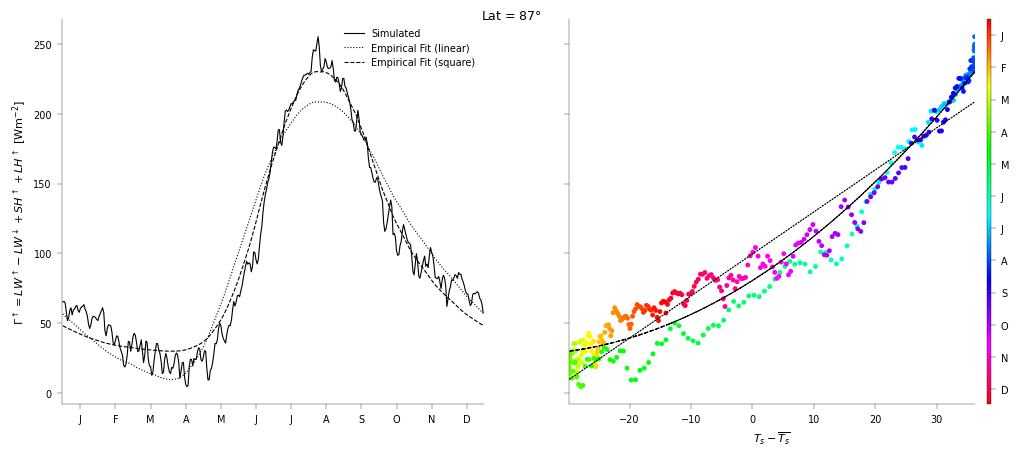

In [159]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

show_linear = True
fig_gamma, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True)
ax[0].plot(ds.time, gamma_up, color='k', label='Simulated')
ax[0].plot(ds.time, square_func(t_surf, *lambda_empirical['linear']), color='k', linestyle=':', label='Empirical Fit (linear)')
# ax[0].plot(ds.time, linear_func_shift(ds.time, *lambda_empirical['linear_shift']), color='r', linestyle=':')
ax[0].plot(ds.time, square_func(t_surf, *lambda_empirical['square']), color='k', linestyle='--', label='Empirical Fit (square)')
# ax[0].plot(ds.time, square_func_shift(ds.time, *lambda_empirical['square_shift']), color='r', linestyle='--')
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
im = ax[1].scatter(t_surf_anom, gamma_up, c=ds.time, cmap='hsv')
ax[1].plot(t_surf_anom, square_func(t_surf, *lambda_empirical['linear']), 
               color='k', linestyle=':')
ax[1].plot(t_surf_anom, square_func(t_surf, *lambda_empirical['square']), 
               color='k', linestyle='--')
cbar = fig_gamma.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[1].set_xlabel('$T_s - \overline{T_s}$')
ax[0].set_xlim(-1, 360)
ax[1].set_xlim(t_surf_anom.min(), t_surf_anom.max())
ax[0].legend()
ax[0].set_xticks(*month_ticks)
fig_gamma.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

### Breakdown into $\lambda$ fitting for each surface flux

Here I fit $\lambda_0 + \lambda_1 T + \lambda_2 T^2$ to each of the individual fluxes that go into $\Gamma^{\uparrow}$. There seems to be a clear division in relationship for days before vs after the hottest day. I think this is because convection acts to give a phase delay.

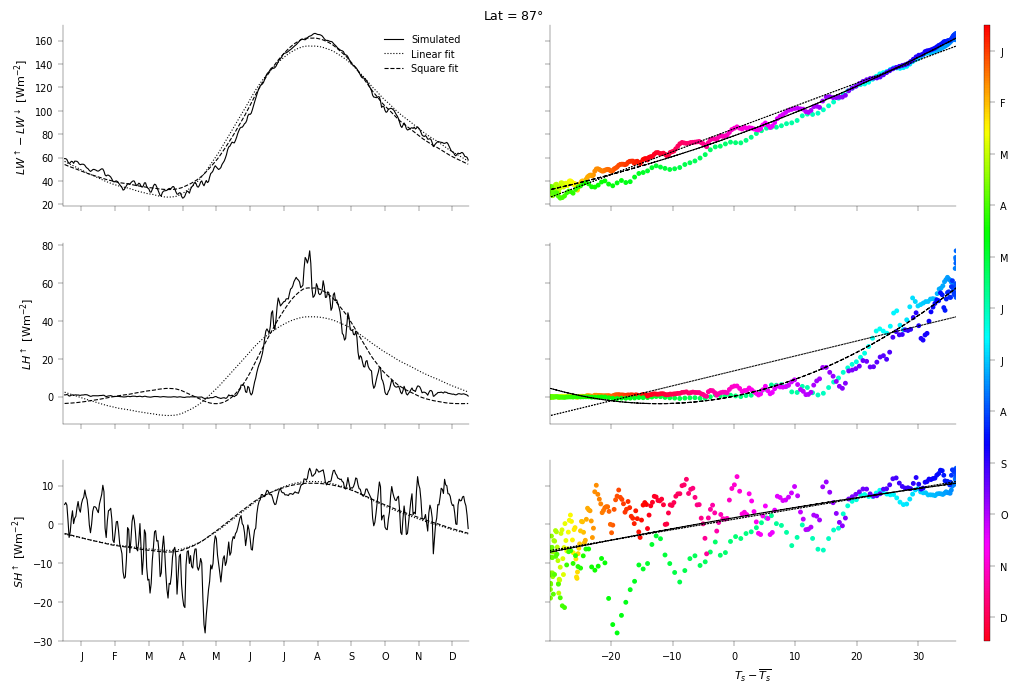

In [160]:
fig, ax = plt.subplots(3,2, figsize=(12, 8), sharey='row', sharex='col')
labels_use = ['$LW^{\\uparrow} - LW^{\\downarrow}$ [Wm$^{-2}$]', '$LH^{\\uparrow}$ [Wm$^{-2}$]', '$SH^{\\uparrow}$ [Wm$^{-2}$]']
sh_approx_params = [0, 0]
for i, var in enumerate([ds.lwup_sfc-ds.lwdn_sfc, ds.flux_lhe, ds.flux_t]):
    ax[i, 0].plot(ds.time, var, color='k', label='Simulated')
    im = ax[i, 1].scatter(t_surf_anom, var, c=ds.time, cmap='hsv')
    fit_param = optimize.curve_fit(linear_func, t_surf, var, param_guess[:-1])[0]
    if var.name == 'flux_t':
        sh_approx_params = fit_param        # use linear approximation for senible heat
    ax[i, 0].plot(ds.time, linear_func(t_surf, *fit_param), color='k', linestyle=':', label='Linear fit')
    ax[i, 1].plot(t_surf_anom, linear_func(t_surf, *fit_param), color='k', linestyle=':')
    fit_param = optimize.curve_fit(square_func, t_surf, var, param_guess)[0]
    ax[i, 0].plot(ds.time, square_func(t_surf, *fit_param), color='k', linestyle='--', label='Square fit')
    ax[i, 1].plot(t_surf_anom, square_func(t_surf, *fit_param), color='k', linestyle='--')
    ax[i, 0].set_ylabel(labels_use[i])
    # fit_param = optimize.curve_fit(square_func, t_surf_anom[no_conv_time_ind], var[no_conv_time_ind], [80, 3, 0])[0]
    # ax[i, 0].plot(ds.time, square_func(t_surf_anom, *fit_param), color='g', linestyle='--', label='Square fit (non convecting)')
    # ax[i, 1].plot(t_surf_anom, square_func(t_surf_anom, *fit_param), color='g', linestyle='--')
ax[0, 0].set_xlim(-1, 360)
ax[0, 1].set_xlim(t_surf_anom.min(), t_surf_anom.max())
ax[0, 0].legend()
ax[-1, 0].set_xticks(*month_ticks)
ax[-1, 1].set_xlabel('$T_s - \overline{T_s}$')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

### Why does $LW^{\uparrow} - LW^{\downarrow}$ show hysteresis?

In the top plot below, we see that $LW^{\uparrow} = \sigma T_s^4$ is an exact equation, so it is entirely in phase with $T_s$ and the 
squared approximation is excellent. 

On the other hand, $LW^{\downarrow}$ has contributions from all levels of the atmosphere so there is no exact equation in terms of just $T_s$. We see that allowing for a phase shift, because the atmosphere responds more slowly to insolation that the surface does, allows for a better fit. I.e. the peak in $LW^{\downarrow}$ comes after the peak in $T_s$ because the atmosphere responds more slowly.

When subtracting the two equations, the linear fit is erronous in the same way for both $LW^{\uparrow}$ and $LW^{\downarrow}$, hence these errors cancel, and the linear fit (with shift for $LW^{\downarrow}$) is pretty good, probably just as good as the squared.

The linear shift fit is $\lambda_0 + \lambda_1 T(t-\Lambda)$, while the squared shift fit is $\lambda_0 + \lambda_1 T(t-\Lambda) + \lambda_2 T(t-\Lambda)^2$.

In [161]:
# Lwup fitting
lwup_sfc_approx_params = {'linear': optimize.curve_fit(linear_func, t_surf, ds.lwup_sfc.to_numpy(), p0=param_guess[:-1])[0], 
                          'square': optimize.curve_fit(square_func, t_surf, ds.lwup_sfc.to_numpy(), p0=param_guess)[0]}
lwup_sfc_approx = {'best': Stefan_Boltzmann*ds.t_surf**4, 
                   'linear': linear_func(t_surf, *lwup_sfc_approx_params['linear']), 
                   'square': square_func(t_surf, *lwup_sfc_approx_params['square'])}

# Lwdn fitting
temp_a_spline_fit = scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), 360), np.append(ds.temp.to_numpy(), ds.temp[0]), bc_type='periodic')

def lwdn_fit_func(temp, a, b):
    return a + Stefan_Boltzmann*(b*temp)**4

def lwdn_fit_func_temp_a_shift(time, a, b, c):
    x_var = temp_a_spline_fit(time-c)
    return a + Stefan_Boltzmann*(b*x_var)**4

def lwdn_fit_func_temp_surf_shift(time, a, b, c):
    x_var = t_surf_spline_fit(time-c)
    return a + Stefan_Boltzmann*(b*x_var)**4

param_guess_lw = [0, 1, 0]
lwdn_sfc_approx_params = {'best_temp_a': optimize.curve_fit(lwdn_fit_func, ds.temp.to_numpy(), ds.lwdn_sfc.to_numpy(), p0=param_guess_lw[:-1])[0],
                          'best_temp_a_shift': optimize.curve_fit(lwdn_fit_func_temp_a_shift, ds.time.to_numpy(), ds.lwdn_sfc.to_numpy(), 
                                                           p0=param_guess_lw)[0], 
                          'best': optimize.curve_fit(lwdn_fit_func, t_surf, ds.lwdn_sfc.to_numpy(), p0=param_guess_lw[:-1])[0], 
                          'best_shift': optimize.curve_fit(lwdn_fit_func_temp_surf_shift, ds.time.to_numpy(), ds.lwdn_sfc.to_numpy(), 
                                                                  p0=param_guess_lw)[0], 
                          'linear': optimize.curve_fit(linear_func, t_surf, ds.lwdn_sfc.to_numpy(), p0=param_guess[:-1])[0], 
                          'square': optimize.curve_fit(square_func, t_surf, ds.lwdn_sfc.to_numpy(), p0=param_guess)[0], 
                          'linear_shift': optimize.curve_fit(linear_func_shift, ds.time, ds.lwdn_sfc.to_numpy(), p0=param_guess)[0], 
                          'square_shift': optimize.curve_fit(square_func_shift, ds.time, ds.lwdn_sfc.to_numpy(), p0=param_guess+[0])[0]}
lwdn_sfc_approx = {'best_temp_a': lwdn_fit_func(ds.temp, *lwdn_sfc_approx_params['best_temp_a']),
                   'best_temp_a_shift': lwdn_fit_func_temp_a_shift(ds.time, *lwdn_sfc_approx_params['best_temp_a_shift']),
                   'best': lwdn_fit_func(ds.t_surf, *lwdn_sfc_approx_params['best']),
                   'best_shift': lwdn_fit_func_temp_surf_shift(ds.time, *lwdn_sfc_approx_params['best_shift']), 
                   'linear': linear_func(t_surf, *lwdn_sfc_approx_params['linear']), 
                   'square': square_func(t_surf, *lwdn_sfc_approx_params['square']), 
                   'linear_shift': linear_func_shift(ds.time, *lwdn_sfc_approx_params['linear_shift']), 
                   'square_shift': square_func_shift(ds.time, *lwdn_sfc_approx_params['square_shift'])}

lwup_minus_lwdn_sfc_approx = {'best': lwup_sfc_approx['best'] - lwdn_sfc_approx['best'], 
                              'best_shift': lwup_sfc_approx['best'] - lwdn_sfc_approx['best_shift'],
                              'linear': lwup_sfc_approx['linear'] - lwdn_sfc_approx['linear'], 
                              'square': lwup_sfc_approx['square'] - lwdn_sfc_approx['square'], 
                              'linear_shift': lwup_sfc_approx['linear'] - lwdn_sfc_approx['linear_shift'], 
                              'square_shift': lwup_sfc_approx['square'] - lwdn_sfc_approx['square_shift']}

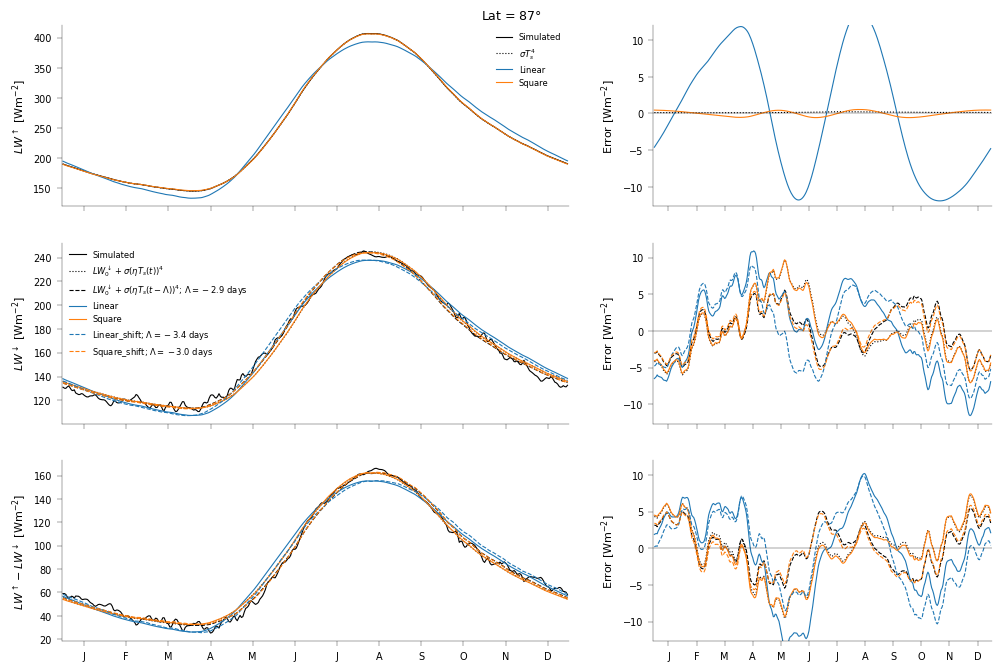

In [162]:
save_lw_decomp_fig = False
error_smooth_window = 10       # average over 10 days to smooth
error_smooth_kernel = np.ones(error_smooth_window)/error_smooth_window
colors_approx = {'best': 'k', 'best_shift': 'k', 'best_temp_a': default_colors[3], 'best_temp_a_shift': default_colors[3],
                 'linear': default_colors[0], 'linear_shift': default_colors[0], 'square': default_colors[1], 
                 'square_shift': default_colors[1]}
linestyles_approx = {}
for key in colors_approx:
    if 'shift' in key:
        linestyles_approx[key] = '--'
    elif 'best' in key:
        linestyles_approx[key] = ':'
    else:
        linestyles_approx[key] = None
        
fig, ax = plt.subplots(3,2, figsize=(12, 8), sharex=True, gridspec_kw={'width_ratios': [1.5, 1]})
ax[0, 0].plot(ds.time, ds.lwup_sfc, color='k', label='Simulated')
for key in lwup_sfc_approx:
    ax[0, 0].plot(ds.time, lwup_sfc_approx[key], color=colors_approx[key], linestyle=linestyles_approx[key], 
                  label='$\sigma T_s^4$' if key=='best' else key.capitalize())
    ax[0, 1].plot(ds.time, ndimage.convolve(ds.lwup_sfc-lwup_sfc_approx[key], error_smooth_kernel, mode='wrap'), 
                  color=colors_approx[key], linestyle=':' if key=='best' else None)

ax[1, 0].plot(ds.time, ds.lwdn_sfc, color='k', label='Simulated')
for key in lwdn_sfc_approx:
    if 'temp_a' in key:
        continue
    labels_use = key.capitalize()
    if key=='best':
        labels_use = '$LW^{\\downarrow}_0 + \sigma (\eta T_s(t))^4$'
    elif key=='best_shift':
        labels_use = "$LW^{\\downarrow}_0 + \sigma (\eta T_s(t-\Lambda))^4$"+f"; $\Lambda = {round(lwdn_sfc_approx_params[key][-1], 1)}$ days"
    elif 'shift' in key:
        labels_use = key.capitalize() + f'; $\Lambda = {round(lwdn_sfc_approx_params[key][-1], 1)}$ days'
    ax[1, 0].plot(ds.time, lwdn_sfc_approx[key], color=colors_approx[key], linestyle=linestyles_approx[key], 
                  label=labels_use)
    ax[1, 1].plot(ds.time, ndimage.convolve(ds.lwdn_sfc-lwdn_sfc_approx[key], error_smooth_kernel, mode='wrap'), 
                  color=colors_approx[key], linestyle=linestyles_approx[key])
    
    
ax[2, 0].plot(ds.time, ds.lwup_sfc-ds.lwdn_sfc, color='k', label='Simulated')
for key in lwup_minus_lwdn_sfc_approx:
    ax[2, 0].plot(ds.time, lwup_minus_lwdn_sfc_approx[key], color=colors_approx[key], linestyle=linestyles_approx[key], label=key.capitalize())
    ax[2, 1].plot(ds.time, ndimage.convolve(ds.lwup_sfc-ds.lwdn_sfc - lwup_minus_lwdn_sfc_approx[key], error_smooth_kernel, mode='wrap'),
                  color=colors_approx[key], linestyle=linestyles_approx[key])

labels_use = ['$LW^{\\uparrow}$ [Wm$^{-2}$]', '$LW^{\\downarrow}$ [Wm$^{-2}$]', '$LW^{\\uparrow} - LW^{\\downarrow}$ [Wm$^{-2}$]']
for i in range(3):
    ax[i, 1].axhline(0, color='k', lw=ax_linewidth)
    ax[i, 0].set_ylabel(labels_use[i])
    ax[i, 1].set_ylabel('Error [Wm$^{-2}$]')
    if i!=2:
        ax[i, 0].legend(fontsize=6)
ax[0, 0].set_xlim(-1, 360)
ax[-1, 0].set_xticks(*month_ticks)
# Set right column to have same y-axis
ax[0, 1].sharey(ax[1, 1])
ax[2, 1].sharey(ax[0, 1])
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9)
if save_lw_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lw_breakdown_lat={lat_plot}.pdf",
                                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Other factors influencing surface energy budget
At higher latitudes when convection not active, don't see this phase delay around hottest day. Difference from linear trend in longwave is due to surface and atmospheric temperatures being different. This is shown below.

Relative humidity also affects the latent heat flux.

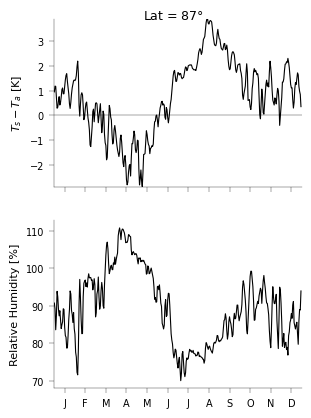

In [163]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(ds.time, ds.t_surf-ds.temp, color='k')
ax[1].plot(ds.time, r_surf*100, color='k')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylim((ds.t_surf-ds.temp).min(), (ds.t_surf-ds.temp).max())
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].set_ylabel('$T_s - T_a$ [K]')
ax[1].set_ylabel('Relative Humidity [%]')
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

## Why does $LH^{\uparrow}$ show hysteresis?
Similar to the $LW$ analysis, I now look at why latent heat shows hysteresis behaviour as well.

The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L598) used for latent heat flux by Isca is:
$LH = L_v C_q\rho |v|(q_{surf} - q_{atm})$

where $C_q$ is the drag coefficient, $\rho$ is the density, $|v|$ is the wind speed, $q_{surf}$ is the saturation specific humidity evaluated at `t_surf` and `p_s` and $q_{atm}$ is specific humidity at the lowest level of the atmosphere.

Not sure why density matches normal temperature, and not virtual temperature.

The key takeaway from the plot below is that the blue line where only relative humidity and surface temperature cause the variation in latent heat captures the seasonal variation well. However, the orange line assuming constant relative humidity does not. Thus, we need to take account of the relative humidity somehow.

In [164]:
def get_latent_heat(temp_surf, temp_a, sphum_a, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf*sigma
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

ds_lat_no_av = ds_base[0].sel(lat=lat_plot, method='nearest').sel(pfull=p_surface_approx, method='nearest').load()

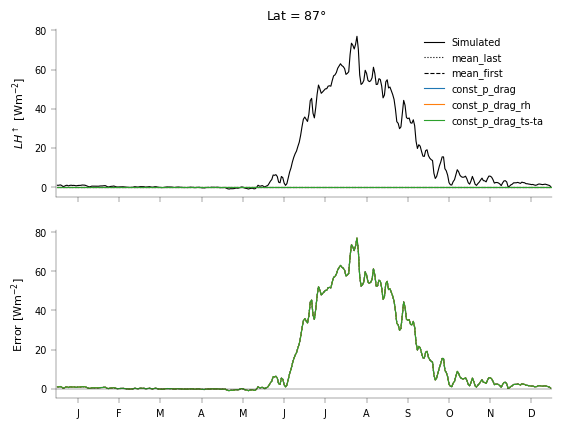

In [165]:
if 'drag_q' in ds_lat_no_av:
    fig, ax = plt.subplots(2,1, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
    ax[0].plot(ds.time, ds.flux_lhe, color='k', label='Simulated')
    if rh_flux_q == 0:
        lh_manual = {'mean_last': annual_mean(get_latent_heat(ds_lat_no_av.t_surf, ds_lat_no_av.temp, ds_lat_no_av.sphum, ds_lat_no_av.ps, 
                                                              w_atm_const, ds_lat_no_av.drag_q)).mean(dim='lon').load().to_numpy(),
                     'mean_first': get_latent_heat(ds.t_surf, ds.temp, ds.sphum, ds.ps, w_atm_const, ds.drag_q),
                     'const_p_drag': get_latent_heat(ds.t_surf, ds.temp, ds.sphum, ds.ps.mean(), w_atm_const, ds.drag_q.mean()), 
                     'const_p_drag_rh': get_latent_heat(ds.t_surf, ds.temp, r_surf.mean() * sphum_sat(ds.temp, ds.pfull*100), 
                                                        ds.ps.mean(), w_atm_const, ds.drag_q.mean()), 
                     'const_p_drag_ts-ta': get_latent_heat(ds.t_surf, ds.temp, r_surf * sphum_sat(ds.t_surf, ds.ps.mean()) * 
                                                           (1 - clausius_clapeyron_factor(ds.t_surf, ds.ps.mean())*np.mean(ds.t_surf-ds.temp)), 
                                                           ds.ps.mean(), w_atm_const, ds.drag_q.mean())}
    else:
        lh_manual = {'mean_last': annual_mean(get_latent_heat(ds_lat_no_av.t_surf, ds_lat_no_av.temp, 
                                                              rh_flux_q * sphum_sat(ds_lat_no_av.temp, sigma_near_surf*ds_lat_no_av.ps), ds_lat_no_av.ps, 
                                                              w_atm_const, ds_lat_no_av.drag_q)).mean(dim='lon').load().to_numpy(),
                     'mean_first': get_latent_heat(ds.t_surf, ds.temp, rh_flux_q * sphum_sat(ds.temp, sigma_near_surf*ds.ps), 
                                                   ds.ps, w_atm_const, ds.drag_q),
                     'const_p_drag': get_latent_heat(ds.t_surf, ds.temp, rh_flux_q * sphum_sat(ds.temp, sigma_near_surf*ds.ps.mean()), ds.ps.mean(), 
                                                     w_atm_const, ds.drag_q.mean()), 
                     'const_p_drag_ts-ta': get_latent_heat(ds.t_surf, ds.temp, rh_flux_q * sphum_sat(ds.t_surf, ds.ps.mean()) * 
                                                           (1 - clausius_clapeyron_factor(ds.t_surf, ds.ps.mean())*np.mean(ds.t_surf-ds.temp)), 
                                                           ds.ps.mean(), w_atm_const, ds.drag_q.mean())}
    
    colors_use = {'mean_last': 'k', 'mean_first': 'k', 'const_p_drag': default_colors[0], 'const_p_drag_rh': default_colors[1], 
                  'const_p_drag_ts-ta': default_colors[2]}
    linestyles_use = {'mean_last': ':', 'mean_first': '--', 'const_p_drag': '-', 'const_p_drag_rh': '-', 'const_p_drag_ts-ta': '-'}
    for key in lh_manual:
        ax[0].plot(ds.time, lh_manual[key], color=colors_use[key], linestyle=linestyles_use[key], label=key)
        ax[1].plot(ds.time, ds.flux_lhe-lh_manual[key], color=colors_use[key], linestyle=linestyles_use[key])    
    ax[0].legend()
    ax[1].axhline(0, color='k', lw=ax_linewidth)
    ax[0].set_xticks(*month_ticks)
    ax[0].set_xlim(-1, 360)
    ax[0].set_ylabel('$LH^{\\uparrow}$ [Wm$^{-2}$]')
    ax[1].set_ylabel('Error [Wm$^{-2}$]')
    fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.92);

The dotted black line is erronous because the saturation specific humidity calculation I use differs from Isca for high temperature. This is shown below.

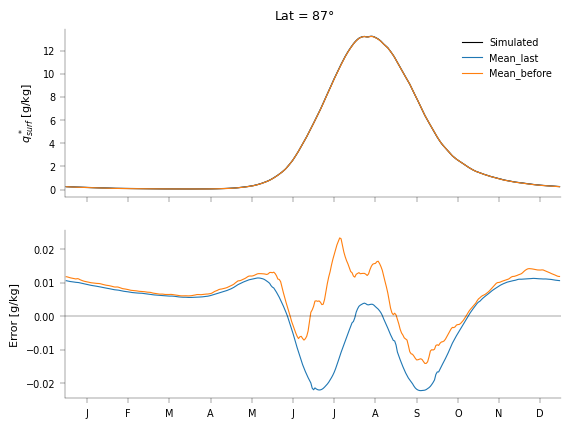

In [166]:
if 'q_surf' in ds_lat_no_av:
    q_surf_calc = {'simulated': annual_mean(ds_lat_no_av.q_surf).mean(dim='lon').to_numpy(), 
                   'mean_last': annual_mean(sphum_sat(ds_lat_no_av.t_surf, ds_lat_no_av.ps)).mean(dim='lon').to_numpy(), 
                   'mean_before': sphum_sat(ds.t_surf, ds.ps).to_numpy()}
    fig, ax = plt.subplots(2,1, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
    for key in q_surf_calc:
        ax[0].plot(ds.time, q_surf_calc[key]*1000, color='k' if key=='simulated' else None, label=key.capitalize())
        if key == 'simulated':
            continue
        ax[1].plot(ds.time, 1000*(q_surf_calc['simulated']-q_surf_calc[key]))
    ax[1].axhline(color='k', lw=ax_linewidth)
    ax[0].legend()
    ax[0].set_xticks(*month_ticks)
    ax[0].set_xlim(-1, 360)
    ax[0].set_ylabel('$q^*_{surf}$ [g/kg]')
    ax[1].set_ylabel('Error [g/kg]')
    fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.92);

### Link between relative humidity and surface temperature
Now that we have established the importance of relative humidity on latent heat, we want to relate relative humidity to surface temperature somehow.
Then we can have an equation for latent heat just in terms of surface temperature.

Below, we see there is a clear phase delay between temperature and relative humidity.

The fit $r_a(T_s) - \overline{r_a} \approx \lambda_{r0} + \lambda_{r1} T_s(t-\Lambda_r)$ seems to work quite well. The phase delay is very different to the longwave radiation phase delay encountered earlier however.

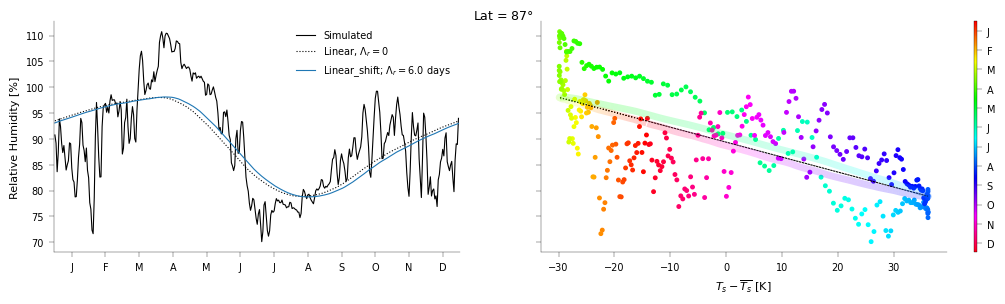

In [167]:
rh_fit_params = {'linear': optimize.curve_fit(linear_func, t_surf, r_surf-r_surf.mean(), p0=[0, 0])[0],
                 'linear_shift': optimize.curve_fit(linear_func_shift, ds.time, r_surf-r_surf.mean(), p0=[0, 0, 0])[0]}
rh_approx = {'linear': linear_func(t_surf, *rh_fit_params['linear']) + r_surf.mean(),
             'linear_shift': linear_func_shift(ds.time, *rh_fit_params['linear_shift']) + r_surf.mean()}
fig, ax = plt.subplots(1,2, figsize=(12, 3), sharey=True)
ax[0].plot(ds.time, 100*r_surf, color='k', label='Simulated')
ax[0].plot(ds.time, 100*rh_approx['linear'], color='k', linestyle=':', label='Linear, $\Lambda_r=0$')
ax[0].plot(ds.time, 100*rh_approx['linear_shift'], color=default_colors[0], 
           label=f"Linear_shift; $\Lambda_r = {round(rh_fit_params['linear_shift'][-1], 1)}$ days")
im = ax[1].scatter(t_surf_anom, r_surf*100, c=ds.time, cmap='hsv')
ax[1].plot(t_surf_anom, 100*rh_approx['linear'], color='k', linestyle=':', label='Linear, $\Lambda_r=0$')
colored_line(t_surf_anom, 100*rh_approx['linear_shift'], ds.time, ax[1], cmap='hsv', alpha=0.2, lw=5)
ax[0].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].set_ylabel('Relative Humidity [%]')
ax[1].set_xlabel('$T_s - \overline{T_s}$ [K]')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.92);

### Decomposition of Latent Heat into Relative Humidity and Temperature Contributions
The relative humidity contribution to latent heat can be written as:

$LH_{r} = -L_v \overline{C_q}\overline{\rho} \overline{|v|}q^*(\overline{T_a})(r_a(t) - \overline{r_a}) \approx 
-L_v \overline{C_q}\overline{\rho} \overline{|v|}q^*(\overline{T_a})(\lambda_{r0} + \lambda_{r1} T_s(t-\Lambda_r))$

where the final approximation comes from the linear_shift fitting above, and gives the relative humidity contribution to latent heat as a function of surface temperature. The approximation shown in the top row below does a pretty good job.

After subtracting $LH_{r}$ from the full latent heat, the residual is related to $T_s$ with no phase shift. This fitting is shown in the second row below. The right plot of this row shows the absence of hysteresis.

Combining these, we get a final approximation for latent heat, shown by the black dotted and dashed lines in the bottom row. Clearly, accounting for the phase relation between relative humidity and temperature is important (blue line shows approximation neglecting this).

The thick multi-coloured lines on the right plot show the linear fit (with phase shift for RH term).

The overall linear approximation for latent heat is of the form:

$LH^{\uparrow} \approx \lambda_{LH0} + \lambda_{LH1}T_s(t) + \lambda_{LH_r}T_s(t-\Lambda_r)$

where $\lambda_{LH_r} = -L_v \overline{C_q}\overline{\rho} \overline{|v|}q^*(\overline{T_a})\lambda_{r1}$

In [168]:
if 'drag_q' in ds:
    if rh_flux_q == 0:
        lh_rh_prefactor = -float(L_v * w_atm_const * ds.drag_q.mean() * get_density(ds.temp.mean(), ds.pfull*100) * 
                                       sphum_sat(ds.temp.mean(), ds.pfull*100))
    else:
        lh_rh_prefactor = 0
    lh_rh_cont_params = {key: [lh_rh_prefactor * rh_fit_params[key][0], lh_rh_prefactor * rh_fit_params[key][1]] for key in rh_fit_params}
    lh_rh_cont_params['linear_shift'] += [rh_fit_params['linear_shift'][2]]
    lh_rh_cont = {'simulated': lh_rh_prefactor * (r_surf-r_surf.mean()), 
                  'linear_shift': linear_func_shift(ds.time, *lh_rh_cont_params['linear_shift']), 
                  'linear': linear_func(t_surf, *lh_rh_cont_params['linear'])}
    lh_temp_cont = {'simulated': ds.flux_lhe - lh_rh_cont['simulated']}
    lh_temp_cont_params = {'linear': optimize.curve_fit(linear_func, t_surf, lh_temp_cont['simulated'], p0=param_guess[:-1])[0], 
                           'square': optimize.curve_fit(square_func, t_surf, lh_temp_cont['simulated'], p0=param_guess)[0]}
    lh_temp_cont['linear'] = linear_func(t_surf, *lh_temp_cont_params['linear'])
    lh_temp_cont['square'] = square_func(t_surf, *lh_temp_cont_params['square'])
    
    lh_approx = {key+'_shift': lh_temp_cont[key] + lh_rh_cont['linear_shift'] for key in ['linear', 'square']}
    lh_approx['linear'] = lh_temp_cont['linear'] + lh_rh_cont['linear']
    lh_approx['square'] = lh_temp_cont['square'] + lh_rh_cont['linear']

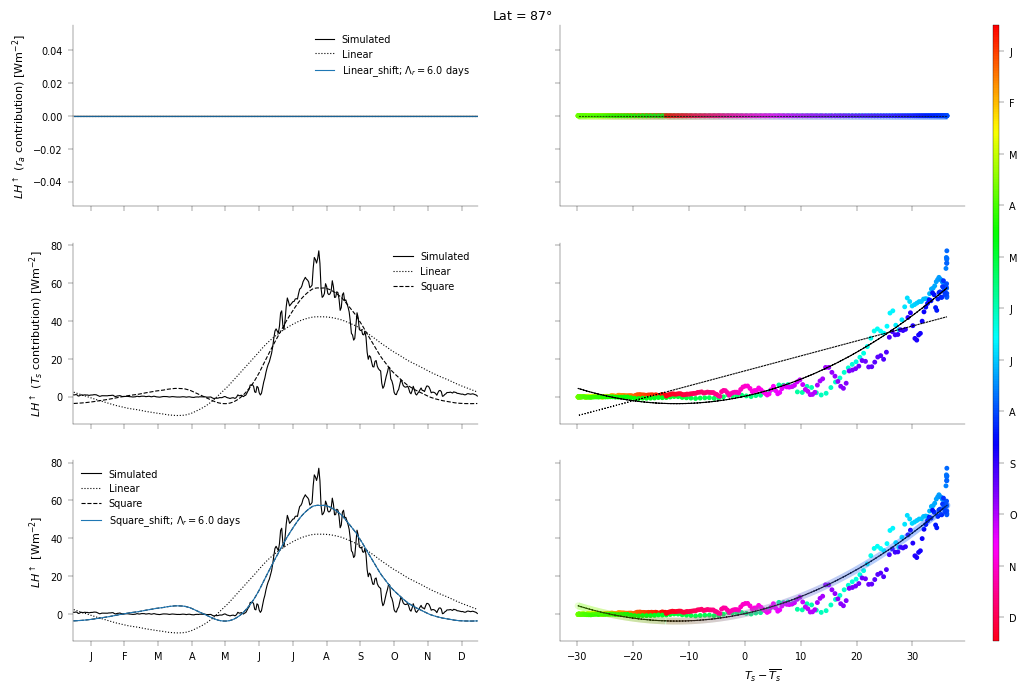

In [169]:
if 'drag_q' in ds:
    save_lh_decomp_fig = False
    show_linear = False          # whether to show linear or square fit in bottom right plot as thick multi coloured line
    linestyles_use = {'linear': ':', 'square': '--', 'simulated': '-'}
    
    fig, ax = plt.subplots(3,2, figsize=(12, 8), sharey='row', sharex='col')
    ax[0, 0].plot(ds.time, lh_rh_cont['simulated'], color='k', label='Simulated')
    ax[0, 0].plot(ds.time, lh_rh_cont['linear'], color='k', 
                  label=f'Linear', linestyle=linestyles_use['linear'])
    ax[0, 0].plot(ds.time, lh_rh_cont['linear_shift'], color=default_colors[0], 
                  label=f"Linear_shift; $\Lambda_r = {round(rh_fit_params['linear_shift'][-1], 1)}$ days")
    ax[0, 1].scatter(t_surf_anom, lh_rh_cont['simulated'], c=ds.time, cmap='hsv')
    ax[0, 1].plot(t_surf_anom, lh_rh_cont['linear'], color='k', 
                  label=f'Linear', linestyle=linestyles_use['linear'])
    colored_line(t_surf_anom, lh_rh_cont['linear_shift'], ds.time, ax[0, 1], cmap='hsv', alpha=0.2, lw=5)
    ax[2, 0].plot(ds.time, ds.flux_lhe, color='k', label='Simulated')
    ax[1, 1].scatter(t_surf_anom, lh_temp_cont['simulated'], c=ds.time, cmap='hsv')
    for key in lh_temp_cont:
        ax[1, 0].plot(ds.time, lh_temp_cont[key], color='k', linestyle=linestyles_use[key], label=key.capitalize())
        if key != 'simulated':
            ax[1, 1].plot(t_surf_anom, lh_temp_cont[key], color='k', linestyle=linestyles_use[key])
            ax[2, 0].plot(ds.time, lh_approx[key], color='k', linestyle=linestyles_use[key], label=key.capitalize())
    ax[2, 0].plot(ds.time, lh_approx['linear_shift' if show_linear else 'square_shift'], color=default_colors[0], 
                  label=f"{'Linear' if show_linear else 'Square'}_shift; $\Lambda_r = {round(rh_fit_params['linear_shift'][-1], 1)}$ days")
    ax[2, 1].scatter(t_surf_anom, ds.flux_lhe, c=ds.time, cmap='hsv')
    ax[2, 1].plot(t_surf_anom, lh_approx['linear' if show_linear else 'square'], color='k', 
                  linestyle=linestyles_use['linear' if show_linear else 'square'])
    colored_line(t_surf_anom, lh_approx['linear_shift' if show_linear else 'square_shift'], ds.time, ax[2, 1], cmap='hsv', alpha=0.2, lw=5)
    
    ax[0, 0].legend()
    ax[0, 0].axhline(0, color='k', lw=ax_linewidth)
    ax[1, 0].legend()
    ax[2, 0].legend()
    ax[0, 0].set_ylabel('$LH^{\\uparrow}$ ($r_a$ contribution) [Wm$^{-2}$]')
    ax[1, 0].set_ylabel('$LH^{\\uparrow}$ ($T_s$ contribution) [Wm$^{-2}$]')
    ax[2, 0].set_ylabel('$LH^{\\uparrow}$ [Wm$^{-2}$]')
    ax[0, 0].set_xlim(-1, 360)
    ax[-1, 0].set_xticks(*month_ticks)
    ax[-1, 1].set_xlabel('$T_s - \overline{T_s}$')
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
    cbar.ax.invert_yaxis()
    cbar.ax.set_yticks(*month_ticks)
    fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9)
    if save_lh_decomp_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/lh_breakdown_lat={lat_plot}.pdf",
                                        dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Effect of $T_s-T_a$
Below, we see that the drag coefficient is related to $T_s-T_a$, and also that $T_s-T_a$ shows some hysteresis.

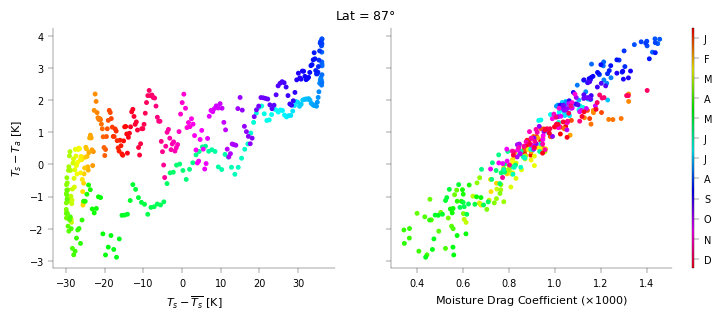

In [170]:
if 'drag_q' in ds:
    fig, ax = plt.subplots(1,2, figsize=(2*1.3*width['one_col'], 1.3*width['one_col']/ar), sharey=True)
    ax[0].scatter(t_surf_anom, ds.t_surf-ds.temp, c=ds.time, cmap='hsv')
    im = ax[1].scatter(ds.drag_q*1000, ds.t_surf-ds.temp, c=ds.time, cmap='hsv')
    ax[0].set_xlabel('$T_s - \overline{T_s}$ [K]')
    ax[1].set_xlabel('Moisture Drag Coefficient $(\\times 1000)$')
    ax[0].set_ylabel('$T_s - T_a$ [K]')
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
    cbar.ax.invert_yaxis()
    cbar.ax.set_yticks(*month_ticks)
    fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.94);

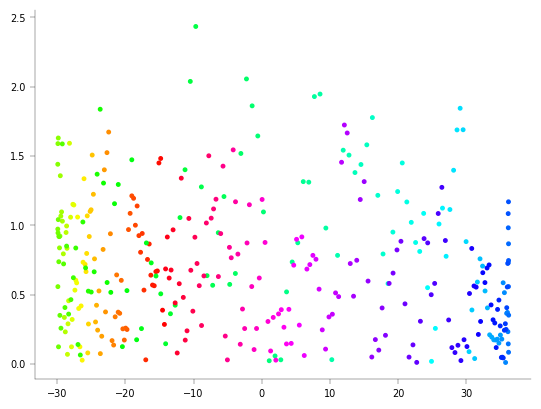

In [171]:
plt.scatter(t_surf_anom, np.sqrt(ds.ucomp**2+ds.vcomp**2), c=ds.time, cmap='hsv')

## Most general form of $\Gamma^{\uparrow}$
The most general form of $\Gamma^{\uparrow} = LW^{\uparrow} - LW^{\downarrow} + LH^{\uparrow} + SH^{\uparrow} \approx \lambda_0 + \lambda_1T_s(t) -  \lambda_{LW^{\downarrow}1}T_s(t-\Lambda_{LW}) - \lambda_{LHr}T_s(t - \Lambda_r)+ \lambda_{sq}T_s(t)^2$

Where all $\lambda$ and $\Phi$ are positive.

So we have one phase delay term from downward longwave radiation, and one from relative humidity contribution to latent heat. We only ever need a $T^2$ term from the temperature contribution to latent heat.

Below I obtain several approximations for $\Gamma^{\uparrow}$:

* `linear`: $\Lambda_{LW} = \Lambda_r = \lambda_{sq} = 0$
* `lw`: $\Lambda_{LW} \neq 0$
* `rh`: $\Lambda_r \neq 0$
* `lh`: $\lambda_{sq} \neq 0$
* `lw_rh`: $\Lambda_{LW} \neq 0; \Lambda_r \neq 0$
* `lw_lh`: $\Lambda_{LW} \neq 0; \lambda_{sq} \neq 0$
* `rh_lw`: $\Lambda_r \neq 0; \lambda_{sq} \neq 0$
* `all`: $\Lambda_{LW} \neq 0; \Lambda_r \neq 0; \lambda_{sq} \neq 0$

In [172]:
gamma_approx_params = {key: 0 for key in ['linear', 'lw', 'rh', 'lh', 'lw_rh', 'lw_lh', 'rh_lh', 'all']}
gamma_approx = {key: np.zeros(ds.time.size) for key in gamma_approx_params}
if 'drag_q' in ds:
    option_lw_effect_phase = False       # if True will include phase effect of longwave as 'lw' option
                                        # if False, will include squared effect of longwave as 'lw' option
    approx_params_use = {'sh': sh_approx_params, 'lwup': 0, 'lwdn': 0, 'lh_temp': 0, 'lh_r': 0}
    for key in gamma_approx_params:
        use_lw = 'lw' in key or key == 'all'
        use_r_phase = 'rh' in key or key == 'all'
        use_lh_square = 'lh' in key or key == 'all'
        if option_lw_effect_phase:
            approx_params_use['lwup'] = lwup_sfc_approx_params['linear']
            approx_params_use['lwdn'] = lwdn_sfc_approx_params['linear_shift'if use_lw else 'linear']
        else:
            approx_params_use['lwup'] = lwup_sfc_approx_params['square' if use_lw else 'linear']
            approx_params_use['lwdn'] = lwdn_sfc_approx_params['square'if use_lw else 'linear']
        approx_params_use['lh_temp'] = lh_temp_cont_params['square' if use_lh_square else 'linear']
        approx_params_use['lh_r'] = lh_rh_cont_params['linear_shift' if use_r_phase else 'linear']
        if not use_lw:
            if not option_lw_effect_phase:
                approx_params_use['lwup'] = np.append(approx_params_use['lwup'], 0)
            approx_params_use['lwdn'] = np.append(approx_params_use['lwdn'], 0)
        if not use_r_phase:
            approx_params_use['lh_r'] = np.append(approx_params_use['lh_r'], 0)
        if not use_lh_square:
            approx_params_use['lh_temp'] = np.append(approx_params_use['lh_temp'], 0)
    
        # Final lambda params to give to get_temp_fourier
        gamma_approx_params[key] = {'amp': np.asarray([approx_params_use['lwup'][0] - approx_params_use['lwdn'][0] + 
                               approx_params_use['lh_temp'][0] + approx_params_use['lh_r'][0] + approx_params_use['sh'][0], 
                               approx_params_use['lwup'][1] + approx_params_use['lh_temp'][1] + approx_params_use['sh'][1], 
                               -approx_params_use['lwdn'][1], approx_params_use['lh_r'][1]]), 
                               'time_lag': np.asarray([0, approx_params_use['lwdn'][2] if option_lw_effect_phase else 0, approx_params_use['lh_r'][2]]), 
                               'square': approx_params_use['lh_temp'][2]}
        if not option_lw_effect_phase:
            gamma_approx_params[key]['square'] += approx_params_use['lwup'][2] - approx_params_use['lwdn'][2]
        gamma_approx[key] = gamma_linear_approx(ds.time, t_surf, gamma_approx_params[key]['amp'], gamma_approx_params[key]['time_lag'], 
                                                gamma_approx_params[key]['square'])

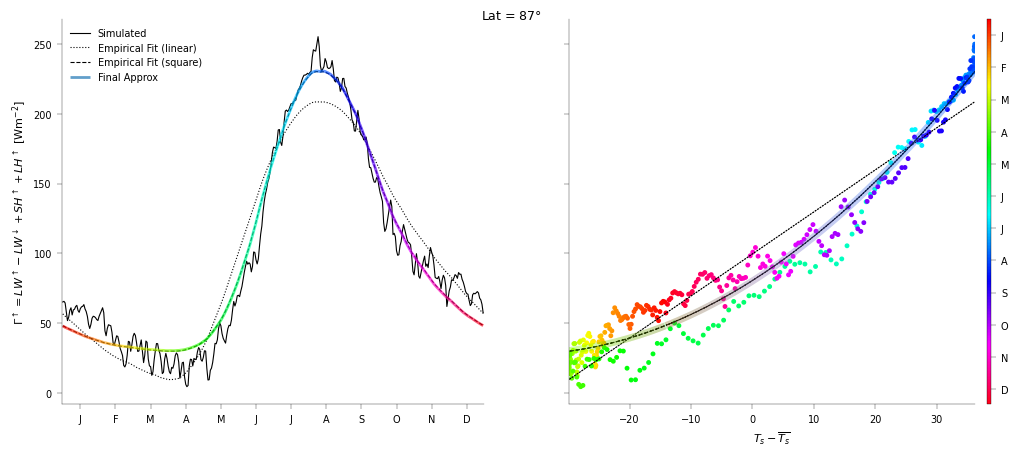

In [173]:
fig = copy.deepcopy(fig_gamma)
ax = fig.axes
colored_line(ds.time, gamma_approx['all'],
             ds.time, ax[0], cmap='hsv', lw=2, alpha=0.7, label='Final Approx')
colored_line(t_surf_anom, gamma_approx['all'], ds.time, ax[1], cmap='hsv', alpha=0.2, lw=5)
ax[0].legend()
fig

### Solution for $T(t)$
Let us seek a fourier series solution for $T(t)$ with two harmonics, so it is the same form as $F_s(t)$:
$$T(t) \approx T_0 + T_1\cos(2\pi ft - \phi_1) + T_2\cos(4\pi ft - \phi_2)$$

This is the exact solution to the equation if $\lambda_{sq}=0$ but is not exact if $\lambda_{sq} \neq 0$.

In [174]:
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
sw_amp_coefs = fourier.get_fourier_fit(ds.time, ds.swdn_sfc, ds.time.size, 2)[1]
sw_phase_coefs = np.zeros(2)
sw_fourier_fit = fourier.fourier_series(ds.time, ds.time.size, sw_amp_coefs, sw_phase_coefs)

temp_amp_coefs = {}
temp_phase_coefs = {}
temp_fourier_fit = {}
if 'drag_q' in ds:
    for key in gamma_approx_params:
        try:
            temp_fourier_fit[key], temp_amp_coefs[key], temp_phase_coefs[key] = \
                get_temp_fourier(ds.time, ds.swdn_sfc, heat_capacity, gamma_approx_params[key]['amp'], gamma_approx_params[key]['time_lag'],
                                 lambda_nl=gamma_approx_params[key]['square'], numerical=False, 
                                 single_harmonic_nl=True)[:3]
        except RuntimeError:
            warnings.warn(f'RuntimeError for {key}: Optimal parameters not found: The maximum number of function evaluations is exceeded')
            temp_fourier_fit[key] = np.zeros(ds.time.size)
            temp_amp_coefs[key] = np.zeros(3)
            temp_phase_coefs[key] = np.zeros(2)
else:
    temp_fourier_fit['linear'], temp_amp_coefs['linear'], temp_phase_coefs['linear'] = \
            get_temp_fourier(ds.time, ds.swdn_sfc, heat_capacity, lambda_empirical['linear'], numerical=False)[:3]
    temp_fourier_fit['square'], temp_amp_coefs['square'], temp_phase_coefs['square'] = \
            get_temp_fourier(ds.time, ds.swdn_sfc, heat_capacity, lambda_empirical['square'][:2], lambda_nl=lambda_empirical['square'][2], 
                             numerical=False, single_harmonic_nl=True)[:3]

In [175]:
# Add solution using non-convective days
key = 'linear_no_conv'
temp_fourier_fit[key], temp_amp_coefs[key], temp_phase_coefs[key] = \
            get_temp_fourier(ds.time, ds.swdn_sfc, heat_capacity, lambda_empirical[key], numerical=False)[:3]
key = 'square_no_conv'
temp_fourier_fit[key], temp_amp_coefs[key], temp_phase_coefs[key] = \
            get_temp_fourier(ds.time, ds.swdn_sfc, heat_capacity, lambda_empirical[key][:2], lambda_nl=lambda_empirical[key][2], 
                             numerical=False, single_harmonic_nl=True)[:3]

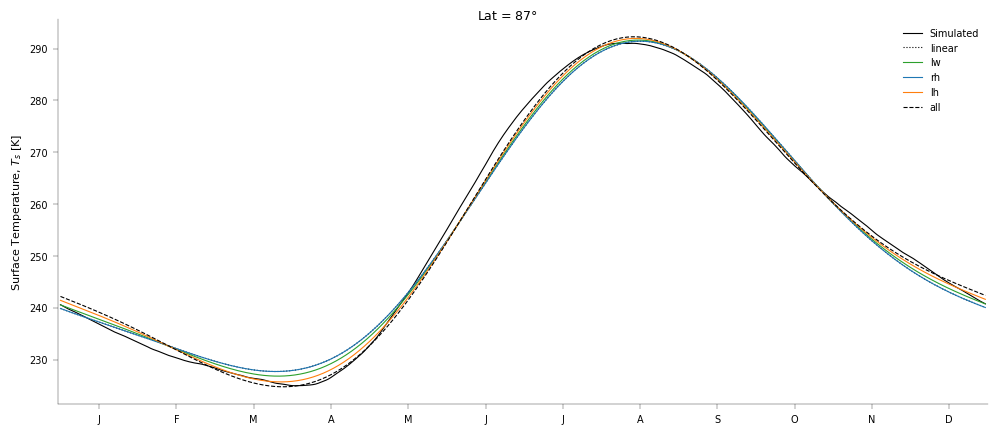

In [176]:
colors_use = {'linear': 'k', 'lw': default_colors[2], 'rh': default_colors[0], 'lh': default_colors[1], 'all': 'k',
              'lh_1_harmonic': default_colors[3], 'lh_linear': 'k', 'square': 'k'}
linestyles_use = {'linear': ':', 'all': '--', 'square': '--'}
fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.plot(ds.time, ds.t_surf, color='k', label='Simulated')
if 'drag_q' in ds:
    keys_use = ['linear', 'lw', 'rh', 'lh', 'all']
else:
    keys_use = ['linear', 'square']
    
for key in keys_use:
    if temp_amp_coefs[key][0] == 0:
        continue
    ax.plot(ds.time, temp_fourier_fit[key], color=colors_use[key], linestyle=linestyles_use[key] if key in linestyles_use else None,
            label=key)

ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
ax.legend()
ax.set_ylabel('Surface Temperature, $T_s$ [K]')
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

# temp_fourier_fit['linear'].plot()
# temp_fourier_fit['lw'].plot()
# # temp_fourier_fit['rh_lh'].plot()
# ds.t_surf.plot(color='k')

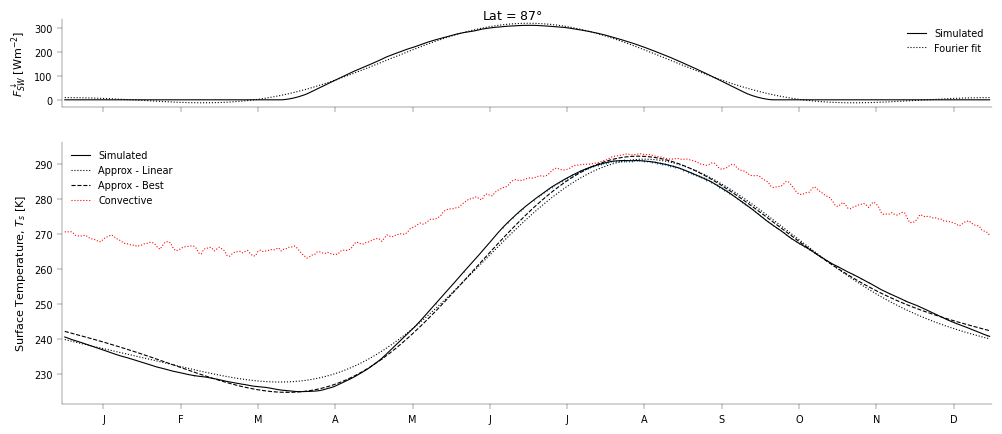

In [177]:
precip_marker_size_func = lambda x: (x*40000)**3        # how to relate precipitation to marker size

fig, ax = plt.subplots(2,1, figsize=(12, 5), sharex=True, height_ratios=[1, 3])
ax[0].plot(ds.time, ds.swdn_sfc, color='k', label='Simulated')
ax[0].plot(ds.time, sw_fourier_fit, color='k', linestyle=':', label='Fourier fit')
ax[1].plot(ds.time, ds.t_surf, color='k', label='Simulated')
ax[1].plot(ds.time, temp_fourier_fit['linear'], color='k', linestyle=':', label='Approx - Linear')
ax[1].plot(ds.time, temp_fourier_fit['all'] if 'all' in temp_fourier_fit else temp_fourier_fit['square'], 
           color='k', linestyle='--', label=f"Approx - {'Best' if 'all' in temp_fourier_fit else 'Square'}")
# ax[1].plot(ds.time, temp_fourier_fit['linear_no_conv'], color='k', linestyle='--', label='Approx - Linear (non-convective)')
# ax[1].plot(ds.time+6, temp_fourier_fit['linear']+ds.t_surf.mean()-1, color='k', linestyle=':', label='Empirical $\lambda$')
# ax[1].plot(ds.time, temp_fourier_fit['linear_no_conv']+ds.t_surf.mean(), color='k', linestyle='--')
# ax[1].plot(ds.time+8, temp_fourier_fit['linear_no_conv']+ds.t_surf.mean()-0.5, linestyle='--', color='green')
# ax[1].plot(ds.time, ds.temp.isel(pfull=ind_surf), color='r')
ax[1].plot(ds.time, temp_surf_conv+ds.t_surf-ds.temp, color='r', linestyle=':', label='Convective')
ax[1].scatter(ds.time, ds.t_surf, 
              s=precip_marker_size_func(ds.precipitation), color=default_colors[0], marker='|')
# ax.plot(time_array, temp_sl_fourier_fit['linear']-temp_sl_fourier_fit['linear'].mean(), color=default_colors[0], lw=1, 
#         label=f'All Linear ($\lambda_0$ = {round(fit_args_linear[0])}, $\lambda_1$ = {round(fit_args_linear[1], 2)})')
# ax.plot(time_array, temp_sl_fourier_fit['square']-temp_sl_fourier_fit['square'].mean(), color=default_colors[1], lw=1, 
#         label=f'All Square ($\lambda_0$ = {round(fit_args_square[0])}, $\lambda_1$ = {round(fit_args_square[1], 2)}, '
#               f'$\lambda_2$ = {round(fit_args_square[2], 2)})')
# ax.plot(time_array, temp_sl_fourier_fit['square3']-temp_sl_fourier_fit['square3'].mean(), color=default_colors[1], linestyle='--', lw=1)
# 
ax[0].set_xlim(-1,360)
ax[1].set_xticks(*month_ticks)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$F_{SW}^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('Surface Temperature, $T_s$ [K]')
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);
# ax.set_ylabel('$T(t) - \overline{T}$ [K]')
# ax.legend(frameon=False)
# fig.suptitle(f'Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$')
# plt.tight_layout()

The temperature tendency is shown below.

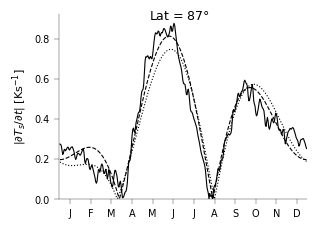

In [178]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(ds.time, np.abs(np.gradient(ds.t_surf)), color='k', label='Simulated')
ax.plot(ds.time, np.abs(np.gradient(temp_fourier_fit['linear'])), color='k', linestyle=':')
ax.plot(ds.time, np.abs(np.gradient(temp_fourier_fit['all' if 'all' in temp_fourier_fit else 'square'])), color='k', linestyle='--')
ax.set_xticks(*month_ticks)
ax.set_xlim(-1, 360)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('$|\partial T_s / \partial t|$ [Ks$^{-1}$]')
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

## Role of $\lambda_{sq}$
Below, we see that if we just include the 1st harmonic in $T^2$, it is still a pretty good approximation of $T^2$ (much better than a constant). The benefit of this, is that it allows an analytic solution with $\lambda_{sq} \neq 0$.

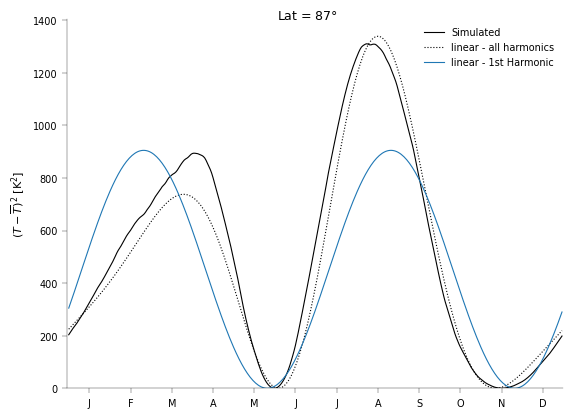

In [179]:
key_plot = 'linear'
fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar))
ax.plot(ds.time, (ds.t_surf-ds.t_surf.mean())**2, color='k', label='Simulated')
ax.plot(ds.time, fourier.fourier_series(ds.time, ds.time.size, [0, temp_amp_coefs[key_plot][1], temp_amp_coefs[key_plot][2]],
                                        [temp_phase_coefs[key_plot][0], temp_phase_coefs[key_plot][1]])**2,
        color='k', linestyle=':', label=f'{key_plot} - all harmonics')
ax.plot(ds.time, fourier.fourier_series(ds.time, ds.time.size, [0, temp_amp_coefs[key_plot][1]], [temp_phase_coefs[key_plot][0]])**2,
        color=default_colors[0], label=f'{key_plot} - 1st Harmonic')
ax.set_xlim(-1,360)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xticks(*month_ticks)
ax.legend()
ax.set_ylabel('$(T-\overline{T})^2$ [K$^2$]')
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

### Analytic Solution
Below we see that the analytic solution (red) assuming only 1st harmonic in $T^2$ term is a good approximation to numerical solution where second harmonic also included (orange).

We see that $\lambda_{sq}$ does not affect the first harmonic at all for analytic cases. It has general effect of shifting phase of 2nd harmonic so hottest day occurs earlier in the year, and coldest day later. It also increases the amplitude slightly.

In [180]:
if 'drag_q' in ds:
    # Get solution where lambda_sq only affects 1st harmonic
    temp_amp_coefs['lh_1_harmonic'], temp_phase_coefs['lh_1_harmonic'] = \
                get_temp_fourier(ds.time, ds.swdn_sfc, heat_capacity, gamma_approx_params['lh']['amp'], gamma_approx_params['lh']['time_lag'],
                                 lambda_nl=gamma_approx_params['lh']['square'], numerical=False, single_harmonic_nl=True)[1:3]
    # Get solution with lh Gamma params but set lambda_sq=0. So allows direct comparison with lh solutions
    temp_amp_coefs['lh_linear'], temp_phase_coefs['lh_linear'] = \
                get_temp_fourier(ds.time, ds.swdn_sfc, heat_capacity, gamma_approx_params['lh']['amp'], gamma_approx_params['lh']['time_lag'],
                                 lambda_nl=0, numerical=False, single_harmonic_nl=True)[1:3]

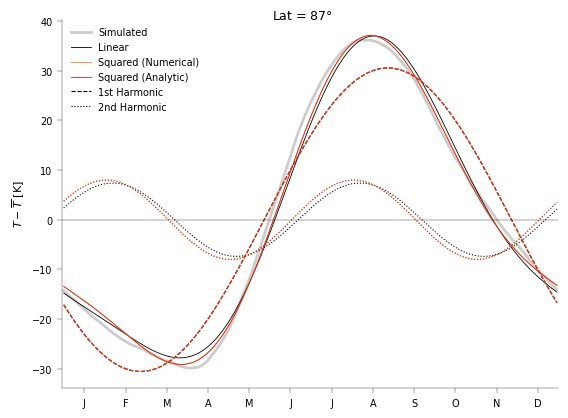

In [181]:
if 'drag_q' in ds:
    labels_use = {'lh_linear': 'Linear', 'lh': 'Squared (Numerical)', 'lh_1_harmonic': 'Squared (Analytic)'}
    fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar))
    ax.plot(ds.time, ds.t_surf-ds.t_surf.mean(),
            color='k', label='Simulated', lw=2, alpha=0.2)
    for key in ['lh_linear', 'lh', 'lh_1_harmonic']:
        ax.plot(ds.time, fourier.fourier_series(ds.time, ds.time.size, [0, temp_amp_coefs[key][1], temp_amp_coefs[key][2]],
                                                [temp_phase_coefs[key][0], temp_phase_coefs[key][1]]),
                color=colors_use[key], label=labels_use[key], lw=0.6)
        ax.plot(ds.time, fourier.fourier_series(ds.time, ds.time.size, [0, temp_amp_coefs[key][1]], [temp_phase_coefs[key][0]]),
                color=colors_use[key], linestyle='--', label='1st Harmonic' if key=='lh_linear' else None)
        ax.plot(ds.time, fourier.fourier_series(ds.time, ds.time.size, [0, 0, temp_amp_coefs[key][2]], [0, temp_phase_coefs[key][1]]),
                color=colors_use[key], linestyle=':', label='2nd Harmonic' if key=='lh_linear' else None)
    
    # Reorder legend
    leg_handles, leg_labels = plt.gca().get_legend_handles_labels()
    leg_order = [0,1,4,5,2,3]
    ax.legend([leg_handles[idx] for idx in leg_order],[leg_labels[idx] for idx in leg_order])
    
    ax.axhline(0, color='k', lw=ax_linewidth)
    ax.set_xlim(-1,360)
    ax.set_xticks(*month_ticks)
    ax.set_ylabel('$T-\overline{T}$ [K]')
    fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

### Effective Shortwave radiation for 2nd Harmonic
The analytical solution for $\lambda_{sq}\neq 0$ amounts to changing the shortwave radiation experienced by the second harmonic from $F_2 \cos(4\pi ft - \varphi_2)$ to $F_2 \cos(4\pi ft - \varphi_2) - \frac{1}{2}\lambda_{sq}T_1^2 \cos(4\pi ft - 2\phi_1)$

Where $T_1$ and $\phi_1$ are the fourier solutions for the 1st harmonic in the case where $\lambda_{sq}=0$.

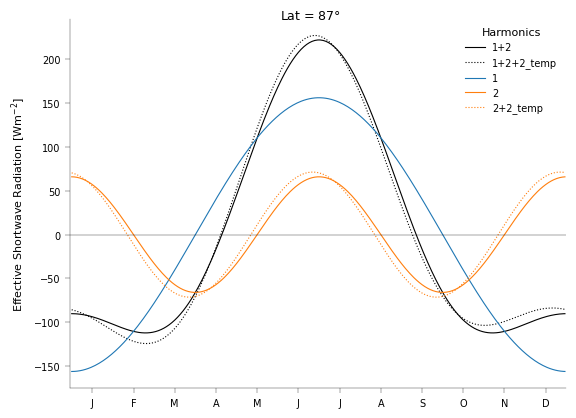

In [182]:
if 'drag_q' in ds:
    fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar))
    sw_fourier_harmonic = {'1': fourier.fourier_series(ds.time, ds.time.size, [0, sw_amp_coefs[1]], [sw_phase_coefs[0]]),
                           '2': fourier.fourier_series(ds.time, ds.time.size, [0, 0, sw_amp_coefs[2]], [0, sw_phase_coefs[1]]),
                           '2_temp_cont': fourier.fourier_series(ds.time, ds.time.size,
                                                                 [0, 0, -0.5 * gamma_approx_params['lh']['square']*temp_amp_coefs['lh_linear'][1]**2],
                                                                 [0, 2*temp_phase_coefs['lh_linear'][0]])}
    ax.plot(ds.time, sw_fourier_harmonic['1'] + sw_fourier_harmonic['2'], color='k', label='1+2')
    ax.plot(ds.time, sw_fourier_harmonic['1'] + sw_fourier_harmonic['2']+sw_fourier_harmonic['2_temp_cont'], color='k', linestyle=':', label='1+2+2_temp')
    ax.plot(ds.time, sw_fourier_harmonic['1'], color=default_colors[0], label='1')
    ax.plot(ds.time, sw_fourier_harmonic['2'], color=default_colors[1], label='2')
    ax.plot(ds.time, sw_fourier_harmonic['2']+sw_fourier_harmonic['2_temp_cont'], color=default_colors[1], linestyle=':', label='2+2_temp')
    ax.legend(title='Harmonics')
    ax.axhline(0, color='k', lw=ax_linewidth)
    ax.set_xlim(-1,360)
    ax.set_xticks(*month_ticks)
    ax.set_ylabel('Effective Shortwave Radiation [Wm$^{-2}$]')
    fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

## Theoretical Temperature Distribution
Below, I plot how well we can predict the temperature distribution, from the simplified surface energy budget.

In [183]:
quant_plot = np.arange(1, 100)
# Compute quantile distribution of full distribution, not just annual mean
# t_surf_quant_full = ds_base[0].sel(lat=lat_plot, method='nearest'
#                                    ).t_surf.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)
#                                                                                                      ).load().quantile(quant_plot/100)
# Compute standard deviation in annual mean distribution across longitudes
t_surf_quant = ds.t_surf.quantile(quant_plot/100)
t_surf_quant_std = np.quantile(annual_mean(ds_base[0].t_surf.sel(lat=lat_plot, method='nearest')).to_numpy(), 
                               quant_plot/100, axis=0).std(axis=-1)

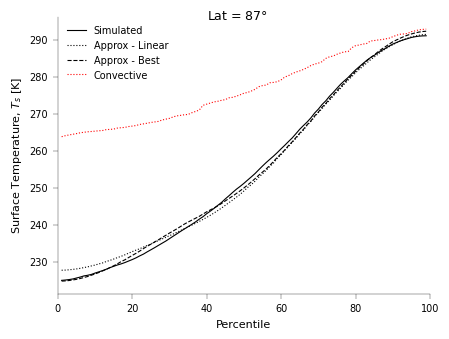

In [184]:
fig, ax = plt.subplots(1,1, figsize=(1.5*width['one_col'], 1.5*width['one_col']/ar))
ax.plot(quant_plot, t_surf_quant, color='k', label='Simulated')
ax.fill_between(quant_plot, t_surf_quant-t_surf_quant_std, t_surf_quant+t_surf_quant_std ,alpha=0.1, facecolor='k')
# ax.plot(quant_plot, t_surf_quant_full, color=default_colors[0], label='Simulated')
ax.plot(quant_plot, (temp_fourier_fit['linear']).quantile(quant_plot/100), color='k', linestyle=':', label='Approx - Linear')
ax.plot(quant_plot, (temp_fourier_fit['all' if 'all' in temp_fourier_fit else 'square']).quantile(quant_plot/100), color='k', linestyle='--',
        label='Approx - Best' if 'all' in temp_fourier_fit else 'Approx - Square')
# (temp_fourier_fit['square_no_conv']+ds.temp.mean()).quantile(quant_plot/100).plot(color='g', linestyle='--', label='Square Fit (non convecting)')
# (temp_fourier_fit['linear_no_conv']+ds.temp.isel(pfull=ind_surf).mean()).quantile(quant_plot/100).plot()
ax.plot(quant_plot, np.quantile(temp_surf_conv+ds.t_surf-ds.temp, quant_plot/100), color='r', linestyle=':', label='Convective')
ax.legend()
ax.set_ylabel('Surface Temperature, $T_s$ [K]')
ax.set_xlabel('Percentile')
ax.set_xlim(0, 100)
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

## Effect of varying $F_2/F_1$, $\lambda$, $C$, $\Lambda_r$ and $\lambda_{sq}$ on hottest date of the year

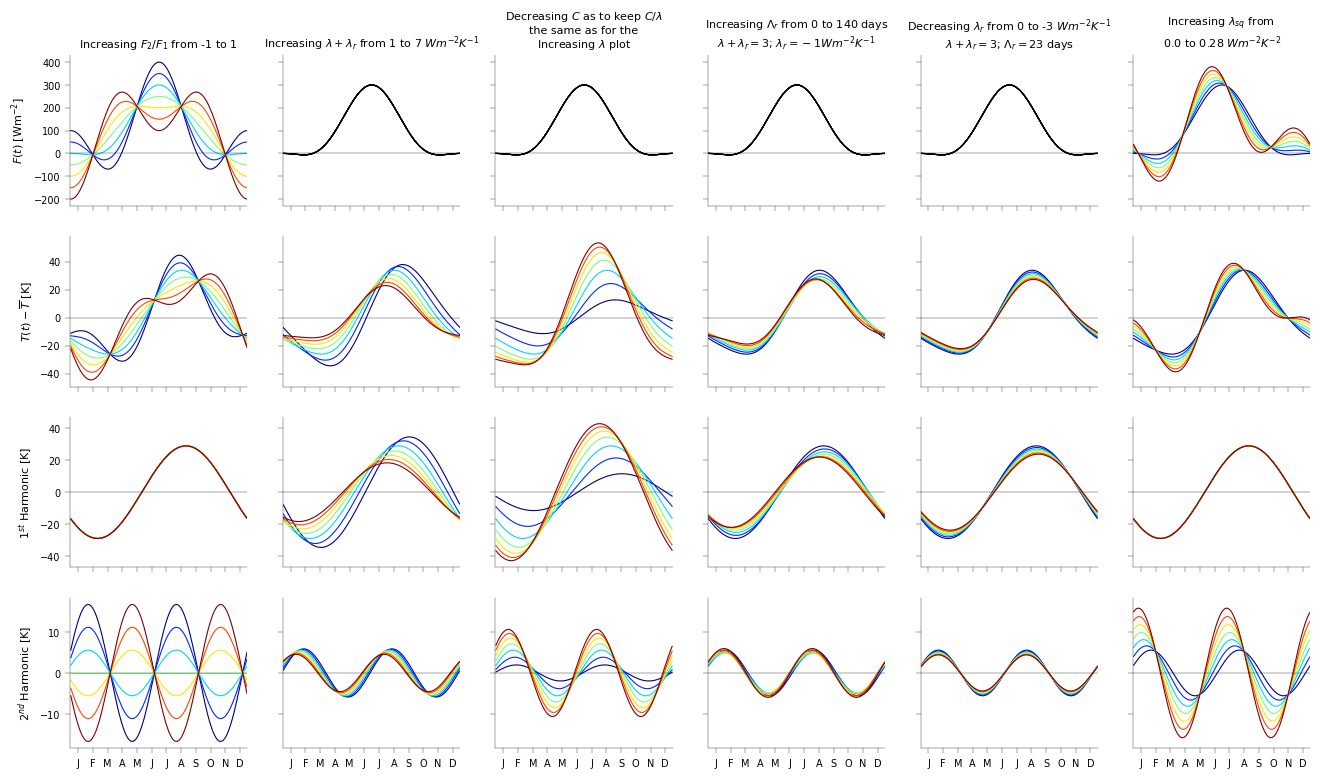

In [185]:
save_schematic_fig = False
n_lines = 7
schem_info = {'sw_amp0': 200, 'sw_amp1': -150, 'sw_amp2': -150 * np.linspace(-1, 1, n_lines),
              'lambda_0': -620, 'lambda': np.linspace(1, n_lines, n_lines)+1, 'lambda_r': -1,
              'lambda_r_array': np.linspace(-3, 0, n_lines)[::-1], 'lambda_total': 3,
              'Lambda_r': np.linspace(0, 140, n_lines), 'lambda_sq': np.linspace(0, 0.04*n_lines, n_lines)}

def plot_temp_fourier(ax_use, temp, temp_amp, temp_phase, color='k'):
    # Plot full fourier temp solution in ax_use[0]
    ax_use[0].plot(ds.time, temp-temp.mean(), color=color)
    # Plot 1st harmonic in ax_use[1]
    ax_use[1].plot(ds.time, fourier.fourier_series(ds.time, ds.time.size, [0, temp_amp[1]], [temp_phase[0]]), color=color)
    # Plot 2nd harmonic in ax_use[2]
    ax_use[2].plot(ds.time, fourier.fourier_series(ds.time, ds.time.size, [0, 0, temp_amp[2]], [0, temp_phase[1]]), color=color)

fig, ax = plt.subplots(4,6, figsize=(16, 9), sharex=True, sharey='row')
color_seq = plt.cm.jet(np.linspace(0,1,n_lines))
for i in range(n_lines):
    sw_plot = fourier.fourier_series(ds.time, ds.time.size, [schem_info['sw_amp0'], schem_info['sw_amp1'],
                                                             schem_info['sw_amp2'][i]], np.zeros(2))
    ax[0, 0].plot(ds.time, sw_plot, color=color_seq[i])
    temp_plot, temp_plot_amp, temp_plot_phase = get_temp_fourier(ds.time, sw_plot, heat_capacity,
                                                                 np.asarray([schem_info['lambda_0'], schem_info['lambda_total']]))[:3]
    plot_temp_fourier(ax[1:, 0], temp_plot, temp_plot_amp, temp_plot_phase, color_seq[i])
    # ax[1, 0].plot(ds.time, temp_plot-np.mean(temp_plot), color=color_seq[i])
    # ax[2, 0].plot(ds.time, fourier.fourier_series(ds.time, ds.time.size, [0, temp_plot_amp[1]], [temp_plot_phase[0]]), color=color_seq[i])

    sw_plot = fourier.fourier_series(ds.time, ds.time.size, [schem_info['sw_amp0'], schem_info['sw_amp1'], schem_info['sw_amp2'][2]], np.zeros(2))
    ax[0, 1].plot(ds.time, sw_plot, color='k')
    ax[0, 2].plot(ds.time, sw_plot, color='k')
    ax[0, 3].plot(ds.time, sw_plot, color='k')
    ax[0, 4].plot(ds.time, sw_plot, color='k')

    # Change lambda
    temp_plot, temp_plot_amp, temp_plot_phase = \
        get_temp_fourier(ds.time, sw_plot, heat_capacity, np.asarray([schem_info['lambda_0'], schem_info['lambda'][i], schem_info['lambda_r']]))[:3]
    plot_temp_fourier(ax[1:, 1], temp_plot, temp_plot_amp, temp_plot_phase, color_seq[i])

    # Change heat capacity
    c_lambda_ratio = heat_capacity / (schem_info['lambda'][i] + schem_info['lambda_r'])
    temp_plot, temp_plot_amp, temp_plot_phase = \
        get_temp_fourier(ds.time, sw_plot, c_lambda_ratio * (schem_info['lambda'][2]+schem_info['lambda_r']),
                         np.asarray([schem_info['lambda_0'], schem_info['lambda'][2], schem_info['lambda_r']]))[:3]
    plot_temp_fourier(ax[1:, 2], temp_plot, temp_plot_amp, temp_plot_phase, color_seq[i])

    # Change relative humidity phasing
    temp_plot, temp_plot_amp, temp_plot_phase = \
        get_temp_fourier(ds.time, sw_plot, heat_capacity, np.asarray([schem_info['lambda_0'], schem_info['lambda_total']-schem_info['lambda_r'],
                                                                      schem_info['lambda_r']]),
                         np.asarray([0, schem_info['Lambda_r'][i]]), lambda_nl=schem_info['lambda_sq'][1]*0, single_harmonic_nl=True)[:3]
    plot_temp_fourier(ax[1:, 3], temp_plot, temp_plot_amp, temp_plot_phase, color_seq[i])

    # For Lambda_r>0, change lambda_r but keep lambda+lambda_r constant
    lambda_total = schem_info['lambda'][2]+schem_info['lambda_r']
    lambda_use = lambda_total - schem_info['lambda_r_array'][i]
    temp_plot, temp_plot_amp, temp_plot_phase = \
        get_temp_fourier(ds.time, sw_plot, heat_capacity, np.asarray([schem_info['lambda_0'], lambda_use,
                                                                      schem_info['lambda_r_array'][i]]),
                         np.asarray([0, schem_info['Lambda_r'][1]]), lambda_nl=schem_info['lambda_sq'][1]*0, single_harmonic_nl=True)[:3]
    plot_temp_fourier(ax[1:, 4], temp_plot, temp_plot_amp, temp_plot_phase, color_seq[i])


    # Change lambda_sq
    temp_plot, temp_plot_amp, temp_plot_phase = \
        get_temp_fourier(ds.time, sw_plot, heat_capacity, np.asarray([schem_info['lambda_0'], schem_info['lambda_total']]),
                         lambda_nl=schem_info['lambda_sq'][i], single_harmonic_nl=True)[:3]
    sw_plot_temp_cont = fourier.fourier_series(ds.time, ds.time.size, [0, 0, -0.5 * schem_info['lambda_sq'][i]*temp_plot_amp[1]**2],
                                               [0, 2*temp_plot_phase[0]])
    ax[0, 5].plot(ds.time, sw_plot+sw_plot_temp_cont, color=color_seq[i])       # plot effective shortwave radiation felt
    plot_temp_fourier(ax[1:, 5], temp_plot, temp_plot_amp, temp_plot_phase, color_seq[i])
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(-1,360)
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_title("Increasing $F_2/F_1$ from -1 to 1")
ax[0, 1].set_title(f"Increasing $\lambda+\lambda_r$ from {int(schem_info['lambda'][0] + schem_info['lambda_r'])} to "
                   f"{int(schem_info['lambda'][-1] + schem_info['lambda_r'])} $Wm^{'{-2}'}K^{'{-1}'}$")
ax[0, 2].set_title('Decreasing $C$ as to keep $C/\lambda$\nthe same as for the\nIncreasing $\lambda$ plot')
ax[0, 3].set_title(f"Increasing $\Lambda_r$ from {int(schem_info['Lambda_r'][0])} to {int(schem_info['Lambda_r'][-1])} days\n"
                   f"$\lambda + \lambda_r = {schem_info['lambda_total']}$; $\lambda_r={schem_info['lambda_r']} Wm^{'{-2}'}K^{'{-1}'}$")
ax[0, 4].set_title(f"Decreasing $\lambda_r$ from {int(schem_info['lambda_r_array'][0])} to {int(schem_info['lambda_r_array'][-1])}"
                   f" $Wm^{'{-2}'}K^{'{-1}'}$\n$\lambda + \lambda_r = {schem_info['lambda_total']}$; "
                   f"$\Lambda_r = {int(schem_info['Lambda_r'][1])}$ days")
ax[0, 5].set_title(f"Increasing $\lambda_{'{sq}'}$ from \n{schem_info['lambda_sq'][0]} to {schem_info['lambda_sq'][-1]} $Wm^{'{-2}'}K^{'{-2}'}$")
ax[0, 0].set_ylabel('$F(t)$ [Wm$^{-2}$]')
ax[1, 0].set_ylabel('$T(t) - \overline{T}$ [K]')
ax[2, 0].set_ylabel('1$^{st}$ Harmonic [K]')
ax[3, 0].set_ylabel('2$^{nd}$ Harmonic [K]')

if save_schematic_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/hottest_day_schematic.pdf",
                                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Long Wave Physical interpretation
Below we see that at high latitudes, a squared term is required for $LW^{\uparrow}$ which is not surprising given that $LW^{\uparrow} = \sigma T_s^4$ is the exact equation.

For $LW^{\downarrow}$, the situation is more complicated, because there is an element of hysteresis as we will explore later. But again, a squared term is required to capture the maxima and minima properly.

When it comes to the combination $LW^{\uparrow} - LW^{\downarrow}$, it seems that the squared fitting is required to capture the maxima.

In [186]:
smooth_ndays = 20
smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays)/smooth_ndays, mode='wrap', axis=ax)

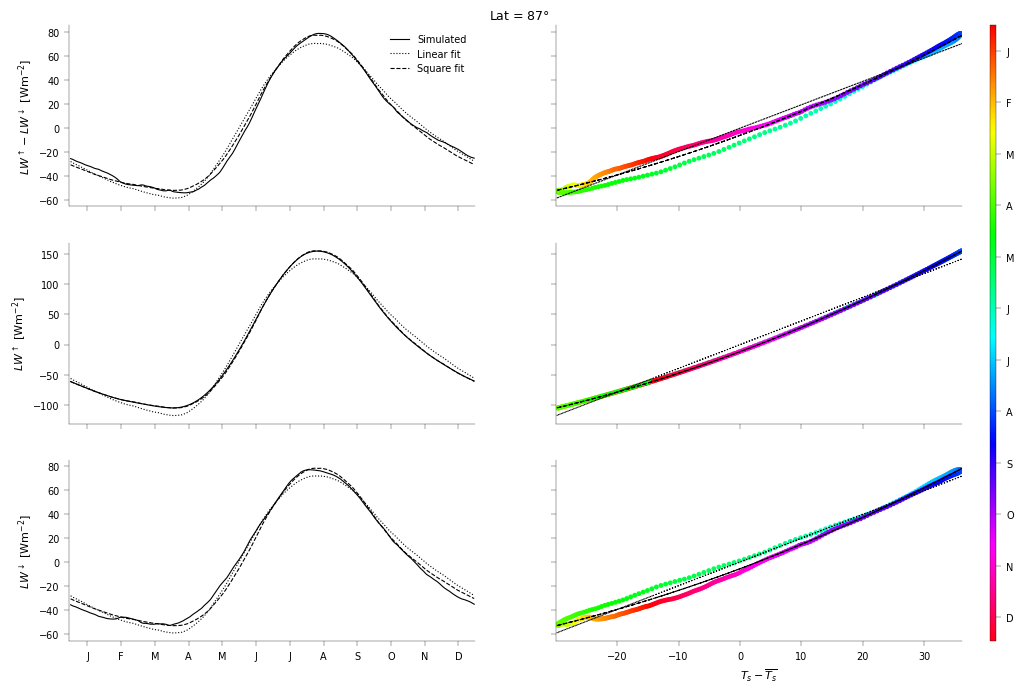

In [187]:
fig, ax = plt.subplots(3,2, figsize=(12, 8), sharey='row', sharex='col')
labels_use = ['$LW^{\\uparrow} - LW^{\\downarrow}$ [Wm$^{-2}$]', '$LW^{\\uparrow}$ [Wm$^{-2}$]', '$LW^{\\downarrow}$ [Wm$^{-2}$]']
sh_approx_params = [0, 0]
for i, var in enumerate([ds.lwup_sfc-ds.lwdn_sfc, ds.lwup_sfc, ds.lwdn_sfc]):
    ax[i, 0].plot(ds.time, smooth_func(var - var.mean()), color='k', label='Simulated')
    im = ax[i, 1].scatter(smooth_func(t_surf_anom), smooth_func(var - var.mean()), c=ds.time, cmap='hsv')
    fit_param = optimize.curve_fit(linear_func, t_surf_anom, var - var.mean(), param_guess[:-1])[0]
    ax[i, 0].plot(ds.time, linear_func(t_surf_anom, *fit_param), color='k', linestyle=':', label='Linear fit')
    ax[i, 1].plot(t_surf_anom, linear_func(t_surf_anom, *fit_param), color='k', linestyle=':')
    fit_param = optimize.curve_fit(square_func, t_surf_anom, var-var.mean(), param_guess)[0]
    ax[i, 0].plot(ds.time, square_func(t_surf_anom, *fit_param), color='k', linestyle='--', label='Square fit')
    ax[i, 1].plot(t_surf_anom, square_func(t_surf_anom, *fit_param), color='k', linestyle='--')
    ax[i, 0].set_ylabel(labels_use[i])
ax[0, 0].set_xlim(-1, 360)
ax[0, 1].set_xlim(t_surf_anom.min(), t_surf_anom.max())
ax[0, 0].legend()
ax[-1, 0].set_xticks(*month_ticks)
ax[-1, 1].set_xlabel('$T_s - \overline{T_s}$')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);

### $LW^{\downarrow}$ Interpretation
If we say that the emission temperature of the atmosphere to the surface is $T_{\epsilon}(t) = \epsilon(t) T_s(t)$, then we expect $LW^{\downarrow}(t) = \sigma T_{\epsilon}^4(t)$. This gives an equation for $\epsilon(t) = \left(\frac{LW^{\downarrow}}{\sigma}\right)^{1/4}\frac{1}{T_s}$.

We see that $\epsilon$ is largest when surface temperature is smallest. This makes sense from Henry 2021b, because in the winter, the lower atmosphere is warmer than the surface, hence emission temperature should be closer to the surface. In the summer however, surface is warmer than the atmosphere and so expect small emission temperature.

The hysteresis is much clearer here, I think it arises due to the advective component. In April and May, sun is moving towards higher latitudes, so pole is colder than surroundings, and thus you advect warmer air from the south increasing the low level atmospheric temperature resulting in a large $\epsilon$. In December and January, sun is moving south so now less of a temperature gradient to the south and low level atmospheric temperature is not increased much by advection, resulting in small $\epsilon$.

This hysteresis is not apparent in the summer because the summer is in radiative-convective equilibrium.

In [188]:
emiss_factor = (ds.lwdn_sfc/Stefan_Boltzmann)**0.25/ds.t_surf
emiss_factor_params = {'linear': optimize.curve_fit(linear_func, t_surf_anom, emiss_factor)[0], 
                       'linear_shift': optimize.curve_fit(linear_func_shift, ds.time, emiss_factor)[0]}
emiss_factor_approx = {'linear': linear_func(t_surf_anom, *emiss_factor_params['linear']), 
                       'linear_shift': linear_func_shift(ds.time, *emiss_factor_params['linear_shift'])}

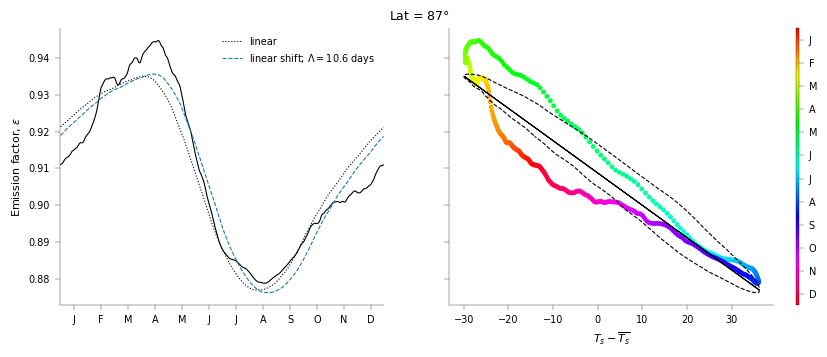

In [250]:
fig, ax = plt.subplots(1,2, figsize=(2*1.5*width['one_col'], 1.5*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(emiss_factor), color='k')
ax[0].plot(ds.time, emiss_factor_approx['linear'], color='k', label='linear', linestyle=':')
ax[0].plot(ds.time, emiss_factor_approx['linear_shift'], color=default_colors[0], linestyle=linestyles_approx['linear_shift'], 
           label=f"linear shift; $\Lambda = {round(emiss_factor_params['linear_shift'][-1], 1)}$ days")
im = ax[1].scatter(smooth_func(t_surf_anom), smooth_func(emiss_factor), c=ds.time, cmap='hsv')
ax[1].plot(t_surf_anom, emiss_factor_approx['linear'], color='k', linestyle=linestyles_approx['linear'])
ax[1].plot(t_surf_anom, emiss_factor_approx['linear_shift'], color='k', linestyle=linestyles_approx['linear_shift'])
ax[0].set_xlim(-1, 360)
ax[0].legend()
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Emission factor, $\epsilon$')
ax[1].set_xlabel('$T_s - \overline{T_s}$')
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.93);

### $LW^{\uparrow} - LW^{\downarrow}$ - Different Contributions
The emission factor contribution to $LW^{\downarrow}$ is given by $LW^{\downarrow}_{\epsilon} = 4\sigma\overline{T_s}^4\overline{\epsilon}^3(\epsilon - \overline{\epsilon})$. The remainder should is just dependent on $T_s$ as shown below. 

When it comes to the final fit, while this effect is observable, it appears that the improvement from the square term is more significant.

In [224]:
lw_cont = {'emission': -4*Stefan_Boltzmann*t_surf.mean()**4*emiss_factor.mean()**3*(emiss_factor-emiss_factor.mean())}
lw_cont['temp'] = ds.lwup_sfc - ds.lwdn_sfc - lw_cont['emission']
lw_cont['temp'] = lw_cont['temp'] - lw_cont['temp'].mean()
lw_cont_params = {'emission_linear': optimize.curve_fit(linear_func, t_surf_anom, lw_cont['emission'])[0], 
                  'emission_linear_shift': optimize.curve_fit(linear_func_shift, ds.time, lw_cont['emission'])[0], 
                  'temp_linear': optimize.curve_fit(linear_func, t_surf_anom, lw_cont['temp'])[0], 
                  'temp_square': optimize.curve_fit(square_func, t_surf_anom, lw_cont['temp'])[0]}
lw_cont_approx = {'emission_linear': linear_func(t_surf_anom, *lw_cont_params['emission_linear']), 
                  'emission_linear_shift': linear_func_shift(ds.time, *lw_cont_params['emission_linear_shift']), 
                  'temp_linear': linear_func(t_surf_anom, *lw_cont_params['temp_linear']), 
                  'temp_square': square_func(t_surf_anom, *lw_cont_params['temp_square'])}

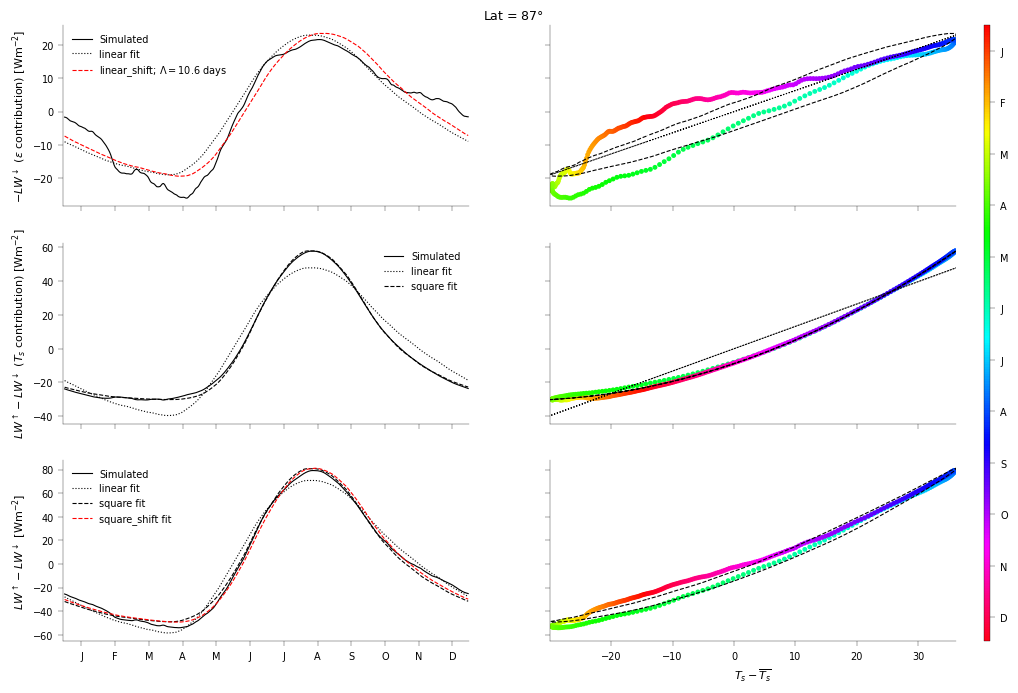

In [248]:
fig, ax = plt.subplots(3,2, figsize=(12, 8), sharey='row', sharex='col')
labels_use = ['$-LW^{\\downarrow}$ ($\epsilon$ contribution) [Wm$^{-2}$]', 
              '$LW^{\\uparrow} - LW^{\\downarrow}$ ($T_s$ contribution) [Wm$^{-2}$]', 
              '$LW^{\\uparrow} - LW^{\\downarrow}$ [Wm$^{-2}$]']
sh_approx_params = [0, 0]
for i, var in enumerate([lw_cont['emission'], lw_cont['temp'], lw_cont['temp']+lw_cont['emission']]):
    ax[i, 0].plot(ds.time, smooth_func(var - var.mean()), color='k', label='Simulated')
    im = ax[i, 1].scatter(smooth_func(t_surf_anom), smooth_func(var - var.mean()), c=ds.time, cmap='hsv')
    ax[i, 0].set_ylabel(labels_use[i])
ax[0, 0].plot(ds.time, lw_cont_approx['emission_linear'], color='k', linestyle=':', label='linear fit')
ax[0, 0].plot(ds.time, lw_cont_approx['emission_linear_shift'], color='r', linestyle='--', 
              label=f"linear_shift; $\Lambda = {round(emiss_factor_params['linear_shift'][-1], 1)}$ days")
ax[0, 1].plot(t_surf_anom, lw_cont_approx['emission_linear'], color='k', linestyle=':')
ax[0, 1].plot(t_surf_anom, lw_cont_approx['emission_linear_shift'], color='k', linestyle='--')

ax[1, 0].plot(ds.time, lw_cont_approx['temp_linear'], color='k', linestyle=':', label='linear fit')
ax[1, 0].plot(ds.time, lw_cont_approx['temp_square'], color='k', linestyle='--', label=f"square fit")
ax[1, 1].plot(t_surf_anom, lw_cont_approx['temp_linear'], color='k', linestyle=':')
ax[1, 1].plot(t_surf_anom, lw_cont_approx['temp_square'], color='k', linestyle='--')

ax[2, 0].plot(ds.time, lw_cont_approx['emission_linear']+lw_cont_approx['temp_linear'], color='k', linestyle=':', label='linear fit')
ax[2, 0].plot(ds.time, lw_cont_approx['emission_linear']+lw_cont_approx['temp_square'], color='k', linestyle='--', label='square fit')
ax[2, 0].plot(ds.time, lw_cont_approx['emission_linear_shift']+lw_cont_approx['temp_square'], color='r', linestyle='--', label=f"square_shift fit")
# ax[2, 1].plot(t_surf_anom, lw_cont_approx['emission_linear']+lw_cont_approx['temp_linear'], color='k', linestyle=':')
# ax[2, 1].plot(t_surf_anom, lw_cont_approx['emission_linear']+lw_cont_approx['temp_square'], color='k', linestyle='--')
ax[2, 1].plot(t_surf_anom, lw_cont_approx['emission_linear_shift']+lw_cont_approx['temp_square'], color='k', linestyle='--')
ax[0, 0].set_xlim(-1, 360)
ax[0, 1].set_xlim(t_surf_anom.min(), t_surf_anom.max())
ax[0, 0].legend()
ax[1, 0].legend()
ax[2, 0].legend()
ax[-1, 0].set_xticks(*month_ticks)
ax[-1, 1].set_xlabel('$T_s - \overline{T_s}$')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.9);